# Cross Validation Experimentation Platform

# Random Forest Regression

### Load libraries

In [4]:
#Load required packages
import pandas as pd
import numpy as np
from random import seed
from random import randrange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.svm import SVR
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor

### Load dataset

Load the dataset here. Maintain the dataset name as df

In [5]:
df = pd.read_csv('airfoil_self_noise.csv')
#df = pd.read_csv('Concrete_Data.csv')

Confirm the number of rows and columns of the dataset.

In [7]:
df.shape

(1503, 6)

### Vary the dataset size

To vary the size of the dataset to be used for experimentation, specify the train_size e.g. 100 to use 100 samples. The train_size is the amount of data that will be used for the experimentation.

In [9]:
data1, data2 = train_test_split(df, train_size=300, random_state=0)

In [10]:
data1.shape

(300, 6)

### Split the train set into k-folds

This function splits the dataset into k equal folds.

In [11]:
def dataset_splitter(dataset, folds=3):
    "A custom function that splits a dataset into k equal folds"
    seed(30)
    splits_list = list()    
    fold_size = int(len(dataset) / folds)
    for i in range(folds):        
        fold = pd.DataFrame(columns = dataset.columns)
        while len(fold) < fold_size:
            if len(dataset) == 0:
                break
            index = randrange(len(dataset))
            selected_row = pd.DataFrame(dataset.loc[(dataset.index == index)])
            fold = pd.concat([fold, selected_row])
            dataset = dataset.reset_index(drop=True)
        splits_list.append(fold)
    return splits_list

#Use function to split a dataset into 10 folds.   
splits = dataset_splitter(data1, 10)
for i in splits:
    print(i.shape)

(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)
(30, 6)


Explore a given fold

In [12]:
splits[3].head(5)

,Frequency,AAttack,Clength,FSVelocity,SSDThickness,SSPLevel
151,6300,0.0,0.1016,71.3,0.001211,129.395
270,800,17.4,0.0254,31.7,0.017663,139.226
164,2500,17.4,0.0254,31.7,0.017663,124.166
10,500,19.7,0.0508,39.6,0.036484,128.444
96,315,8.9,0.1016,39.6,0.012460,135.380


### Train, Validation and Test Sets

Using the 10 splits we created above
- Trainng set: 80% (split 0 to split 7)
- Reduced Training set: 70% (split 0 split 6)
- Validation set: 10% (split 7)
- Testing set: 20% (split 8 and split 9


In [187]:
#Create Train set
training_set = pd.DataFrame(columns = splits[0].columns)
training_set = pd.concat([training_set, splits[0], splits[1], splits[2], splits[3], splits[4], splits[5], splits[6], splits[7]])

Xtraining = training_set.iloc[:, 0:(len(training_set.columns)-1)]
ytraining = training_set.iloc[:, len(training_set.columns)-1]

#Create reduced Train set
rtraining_set = pd.DataFrame(columns = splits[0].columns)
rtraining_set = pd.concat([rtraining_set, splits[0], splits[1], splits[2], splits[3], splits[4], splits[5], splits[6]])

Xrtraining = rtraining_set.iloc[:, 0:(len(rtraining_set.columns)-1)]
yrtraining = rtraining_set.iloc[:, len(rtraining_set.columns)-1]

#Create Validation set
validation_set = splits[7]
Xvalidation = validation_set.iloc[:, 0:(len(validation_set.columns)-1)]
yvalidation = validation_set.iloc[:, len(validation_set.columns)-1]

#Create test set
testing_set = pd.DataFrame(columns = splits[0].columns)
testing_set = pd.concat([testing_set, splits[8], splits[9]])
Xtesting = testing_set.iloc[:, 0:(len(testing_set.columns)-1)]
ytesting = testing_set.iloc[:, len(testing_set.columns)-1]

In [188]:
print('Training set:', training_set.shape)
print('Reduced training set:', rtraining_set.shape)
print('Validation set:', validation_set.shape)
print('Testing set:', testing_set.shape)

Training set: (240, 6)
Reduced training set: (210, 6)
Validation set: (30, 6)
Testing set: (60, 6)


### Run: Train, Validate, Test with SVR

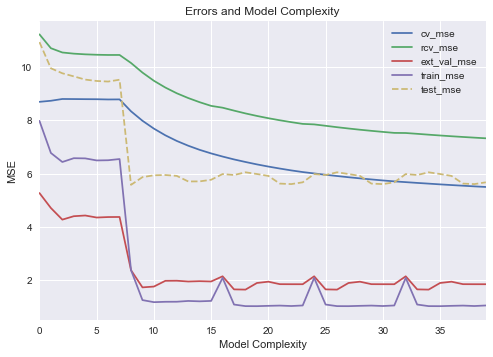

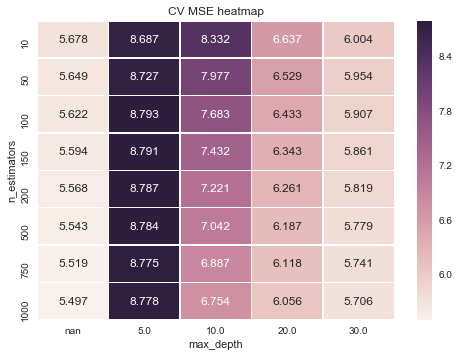

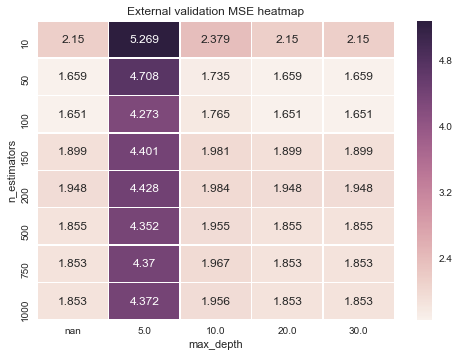

n_estimator: 100.0 max_depth: 20.0 MSE: 1.6508801538


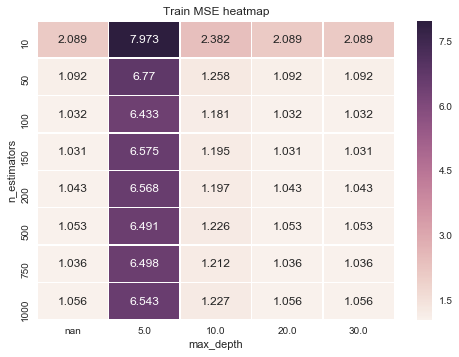

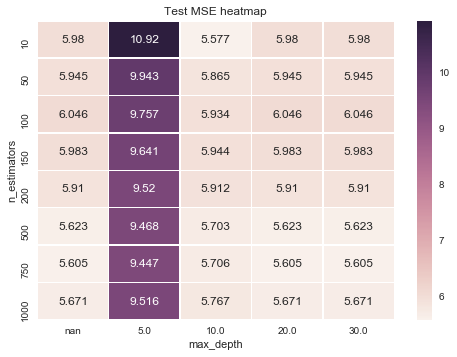

In [189]:
#split training subsets into k folds
folds = dataset_splitter(training_set, 5) #split the training subset fo 5-fold CV
rfolds = dataset_splitter(rtraining_set, 5) #split the rtraining subset fo 5-fold CV

#parameter values
n_estimators = [10, 50, 100, 150, 200, 500, 750, 1000] #try 20 to 200, not too many steps
max_depths = [5, 10, 20, 30, None] #try 10-50

#define variables and lists
n_estimators_out = []
max_depth_out = []
cv_mse_out = []
cv_iter_mse = []
test_mse_out = []
ext_val_mse_out =[]
train_mse_out = []
rcv_mse_out = []
rcv_iter_mse = []

#train, validate and test
for md in max_depths:
    for n in n_estimators:
        model = RandomForestRegressor(n_estimators = n, max_depth = md, random_state = 42)
        
    #produce training error on rtraining
        model.fit(Xrtraining, yrtraining)
        pred_nocv = model.predict(Xtraining)
        train_mse = metrics.mean_squared_error(ytraining, pred_nocv)
        train_mse_out.append(train_mse)
    #end training error
        
    #k-fold CV on training_set
        for i in range(len(folds)):
            test_set = folds[i]    
            Xtest = test_set.iloc[:, 0:(len(test_set.columns)-1)]
            ytest = test_set.iloc[:, len(test_set.columns)-1]   
    
            train_set = pd.DataFrame(columns = folds[0].columns)    
            for j in range(len(folds)):
                if j == i:
                    continue
                train_set = pd.concat([train_set, folds[j]])
            Xtrain = train_set.iloc[:, 0:(len(train_set.columns)-1)]
            ytrain = train_set.iloc[:, len(train_set.columns)-1]        
            
            model.fit(Xtrain, ytrain)
            pred_ytest = model.predict(Xtest)
            iter_mse = metrics.mean_squared_error(ytest, pred_ytest)    
            cv_iter_mse.append(iter_mse)
            cv_mse = np.mean(cv_iter_mse)
        cv_mse_out.append(cv_mse)   
    #end k-fold CV
    
    #k-fold CV on rtraining_set
        for i in range(len(rfolds)):
            rtest_set = rfolds[i]    
            Xrtest = rtest_set.iloc[:, 0:(len(rtest_set.columns)-1)]
            yrtest = rtest_set.iloc[:, len(rtest_set.columns)-1]   
    
            rtrain_set = pd.DataFrame(columns = rfolds[0].columns)    
            for j in range(len(rfolds)):
                if j == i:
                    continue
                rtrain_set = pd.concat([rtrain_set, rfolds[j]])
            Xrtrain = rtrain_set.iloc[:, 0:(len(rtrain_set.columns)-1)]
            yrtrain = rtrain_set.iloc[:, len(rtrain_set.columns)-1]        
            
            model.fit(Xrtrain, yrtrain)
            pred_yrtest = model.predict(Xrtest)
            riter_mse = metrics.mean_squared_error(yrtest, pred_yrtest)    
            rcv_iter_mse.append(riter_mse)
            rcv_mse = np.mean(rcv_iter_mse)
        rcv_mse_out.append(rcv_mse)   
    #end k-fold CV
    
    #external validation
        model.fit(Xrtraining, yrtraining)
        predict_ext_validation = model.predict(Xvalidation)
        ext_val_mse = metrics.mean_squared_error(yvalidation, predict_ext_validation)
        ext_val_mse_out.append(ext_val_mse)
    #end external validation
    
    #testing on unseen data
        #model.fit(Xrtesing, yrtraining)
        pred_on_test = model.predict(Xtesting)
        test_mse = metrics.mean_squared_error(ytesting, pred_on_test)
        test_mse_out.append(test_mse)
    #end testing on unseen data       
    
    #re-capture parameters used in iteration
        n_estimators_out.append(n)
        max_depth_out.append(md)
             
#create dictionary of parameters and mses then convert into a dataframe
outputs = {'n_estimators': n_estimators_out, 
           'max_depth': max_depth_out, 
           'cv_mse': cv_mse_out, 
           'train_mse': train_mse_out,
           'ext_val_mse': ext_val_mse_out,
           'test_mse': test_mse_out,
           'rcv_mse': rcv_mse_out
          }
outputs = pd.DataFrame(outputs) 
outputs2= outputs #keep data for plotting before pivoting 

#store best parameters and score
best_score = outputs['ext_val_mse'].min()
best_score_rows = outputs.loc[(outputs['ext_val_mse'] == best_score)]
if len(best_score_rows.index) == 1:
    best_parameters = best_score_rows
elif len(best_score_rows.index) > 1:
    best_parameters = best_score_rows.loc[best_score_rows['n_estimators'] == best_score_rows['n_estimators'].min()] 

best_n_estimator = best_parameters.iloc[0]['n_estimators']
best_max_depth = best_parameters.iloc[0]['max_depth']
best_mse = best_parameters.iloc[0]['ext_val_mse']

#plot line graphs
ax = plt.gca()
outputs2.plot(kind='line', y='cv_mse',ax=ax)
outputs2.plot(kind='line', y='rcv_mse',ax=ax)
outputs2.plot(kind='line', y='ext_val_mse',ax=ax)
outputs2.plot(kind='line', y='train_mse',ax=ax)
outputs2.plot(linestyle='dashed', y='test_mse', ax=ax)
plt.title('Errors and Model Complexity')
plt.xlabel('Model Complexity')
plt.ylabel('MSE')
plt.show()

#plot heatmaps
outputs_cv_train = outputs.pivot('n_estimators', 'max_depth', 'cv_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("CV MSE heatmap")
plt.show()

outputs_ext_valid = outputs.pivot('n_estimators', 'max_depth', 'ext_val_mse')
sns.heatmap(outputs_ext_valid, annot=True, linewidths=.5, fmt='.4g')
plt.title("External validation MSE heatmap")
plt.show()

print('n_estimator:', best_n_estimator, 'max_depth:', best_max_depth, 'MSE:', best_mse)

outputs_train = outputs.pivot('n_estimators', 'max_depth', 'train_mse')
sns.heatmap(outputs_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("Train MSE heatmap")
plt.show()

outputs_test = outputs.pivot('n_estimators', 'max_depth', 'test_mse')
sns.heatmap(outputs_test, annot=True, linewidths=.5, fmt='.4g')
plt.title("Test MSE heatmap")
plt.show()



### The code below is not part of the Experimentation Platform, but was used for capturing results from the repeated experiments with different seeds. The outputs were written to file and then called again to obtain the averages. The seeds used were 10, 20 and 30. Ech individual block to be run with the Charts creation blosk at the bottom to produce averaged plots.

In [28]:
#write to CSV
#outputs2.to_csv("concrete900RFRseed10.csv")

In [14]:
#900 samples

#Combine 3 sets
concrete900RFRseed10 = pd.read_csv("outputs/concrete900RFRseed10.csv")
concrete900RFRseed20 = pd.read_csv("outputs/concrete900RFRseed20.csv")
concrete900RFRseed30 = pd.read_csv("outputs/concrete900RFRseed30.csv")
concrete900RFR_avg = pd.DataFrame(columns = concrete900RFRseed10.columns)

concrete900RFR_avg["n_estimators"] = concrete900RFRseed10["n_estimators"]
concrete900RFR_avg["max_depth"] = concrete900RFRseed10["max_depth"]
concrete900RFR_avg["cv_mse"] = (concrete900RFRseed10["cv_mse"] + concrete900RFRseed20["cv_mse"] + concrete900RFRseed30["cv_mse"])/3
concrete900RFR_avg["ext_val_mse"] = (concrete900RFRseed10["ext_val_mse"] + concrete900RFRseed20["ext_val_mse"] + concrete900RFRseed30["ext_val_mse"])/3
concrete900RFR_avg["train_mse"] = (concrete900RFRseed10["train_mse"] + concrete900RFRseed20["train_mse"] + concrete900RFRseed30["train_mse"])/3
concrete900RFR_avg["rcv_mse"] = (concrete900RFRseed10["rcv_mse"] + concrete900RFRseed20["rcv_mse"] + concrete900RFRseed30["rcv_mse"])/3
concrete900RFR_avg["test_mse"] = (concrete900RFRseed10["test_mse"] + concrete900RFRseed20["test_mse"] + concrete900RFRseed30["test_mse"])/3
#concrete900_avg

outputs = concrete900RFR_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 900
nsamples = str(nsamples)


In [15]:
#600 samples

#Combine 3 sets
concrete600RFRseed10 = pd.read_csv("outputs/concrete600RFRseed10.csv")
concrete600RFRseed20 = pd.read_csv("outputs/concrete600RFRseed20.csv")
concrete600RFRseed30 = pd.read_csv("outputs/concrete600RFRseed30.csv")
concrete600RFR_avg = pd.DataFrame(columns = concrete600RFRseed10.columns)

concrete600RFR_avg["n_estimators"] = concrete600RFRseed10["n_estimators"]
concrete600RFR_avg["max_depth"] = concrete600RFRseed10["max_depth"]
concrete600RFR_avg["cv_mse"] = (concrete600RFRseed10["cv_mse"] + concrete600RFRseed20["cv_mse"] + concrete600RFRseed30["cv_mse"])/3
concrete600RFR_avg["ext_val_mse"] = (concrete600RFRseed10["ext_val_mse"] + concrete600RFRseed20["ext_val_mse"] + concrete600RFRseed30["ext_val_mse"])/3
concrete600RFR_avg["train_mse"] = (concrete600RFRseed10["train_mse"] + concrete600RFRseed20["train_mse"] + concrete600RFRseed30["train_mse"])/3
concrete600RFR_avg["rcv_mse"] = (concrete600RFRseed10["rcv_mse"] + concrete600RFRseed20["rcv_mse"] + concrete600RFRseed30["rcv_mse"])/3
concrete600RFR_avg["test_mse"] = (concrete600RFRseed10["test_mse"] + concrete600RFRseed20["test_mse"] + concrete600RFRseed30["test_mse"])/3
#concrete600_avg

outputs = concrete600RFR_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 600
nsamples = str(nsamples)



In [16]:
#300 samples

#Combine 3 sets
concrete300RFRseed10 = pd.read_csv("outputs/concrete300RFRseed10.csv")
concrete300RFRseed20 = pd.read_csv("outputs/concrete300RFRseed20.csv")
concrete300RFRseed30 = pd.read_csv("outputs/concrete300RFRseed30.csv")
concrete300RFR_avg = pd.DataFrame(columns = concrete300RFRseed10.columns)

concrete300RFR_avg["n_estimators"] = concrete300RFRseed10["n_estimators"]
concrete300RFR_avg["max_depth"] = concrete300RFRseed10["max_depth"]
concrete300RFR_avg["cv_mse"] = (concrete300RFRseed10["cv_mse"] + concrete300RFRseed20["cv_mse"] + concrete300RFRseed30["cv_mse"])/3
concrete300RFR_avg["ext_val_mse"] = (concrete300RFRseed10["ext_val_mse"] + concrete300RFRseed20["ext_val_mse"] + concrete300RFRseed30["ext_val_mse"])/3
concrete300RFR_avg["train_mse"] = (concrete300RFRseed10["train_mse"] + concrete300RFRseed20["train_mse"] + concrete300RFRseed30["train_mse"])/3
concrete300RFR_avg["rcv_mse"] = (concrete300RFRseed10["rcv_mse"] + concrete300RFRseed20["rcv_mse"] + concrete300RFRseed30["rcv_mse"])/3
concrete300RFR_avg["test_mse"] = (concrete300RFRseed10["test_mse"] + concrete300RFRseed20["test_mse"] + concrete300RFRseed30["test_mse"])/3
#concrete300_avg

outputs = concrete300RFR_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 300
nsamples = str(nsamples)



In [17]:
#100 samples

#Combine 3 sets
concrete100RFRseed10 = pd.read_csv("outputs/concrete100RFRseed10.csv")
concrete100RFRseed20 = pd.read_csv("outputs/concrete100RFRseed20.csv")
concrete100RFRseed30 = pd.read_csv("outputs/concrete100RFRseed30.csv")
concrete100RFR_avg = pd.DataFrame(columns = concrete100RFRseed10.columns)

concrete100RFR_avg["n_estimators"] = concrete100RFRseed10["n_estimators"]
concrete100RFR_avg["max_depth"] = concrete100RFRseed10["max_depth"]
concrete100RFR_avg["cv_mse"] = (concrete100RFRseed10["cv_mse"] + concrete100RFRseed20["cv_mse"] + concrete100RFRseed30["cv_mse"])/3
concrete100RFR_avg["ext_val_mse"] = (concrete100RFRseed10["ext_val_mse"] + concrete100RFRseed20["ext_val_mse"] + concrete100RFRseed30["ext_val_mse"])/3
concrete100RFR_avg["train_mse"] = (concrete100RFRseed10["train_mse"] + concrete100RFRseed20["train_mse"] + concrete100RFRseed30["train_mse"])/3
concrete100RFR_avg["rcv_mse"] = (concrete100RFRseed10["rcv_mse"] + concrete100RFRseed20["rcv_mse"] + concrete100RFRseed30["rcv_mse"])/3
concrete100RFR_avg["test_mse"] = (concrete100RFRseed10["test_mse"] + concrete100RFRseed20["test_mse"] + concrete100RFRseed30["test_mse"])/3
#concrete100_avg

outputs = concrete100RFR_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 100
nsamples = str(nsamples)


In [18]:
#100 samples

#Combine 3 sets
airfoil100RFRseed10 = pd.read_csv("outputs/airfoil100RFRseed10.csv")
airfoil100RFRseed20 = pd.read_csv("outputs/airfoil100RFRseed20.csv")
airfoil100RFRseed30 = pd.read_csv("outputs/airfoil100RFRseed30.csv")
airfoil100RFR_avg = pd.DataFrame(columns = airfoil100RFRseed10.columns)

airfoil100RFR_avg["n_estimators"] = airfoil100RFRseed10["n_estimators"]
airfoil100RFR_avg["max_depth"] = airfoil100RFRseed10["max_depth"]
airfoil100RFR_avg["cv_mse"] = (airfoil100RFRseed10["cv_mse"] + airfoil100RFRseed20["cv_mse"] + airfoil100RFRseed30["cv_mse"])/3
airfoil100RFR_avg["ext_val_mse"] = (airfoil100RFRseed10["ext_val_mse"] + airfoil100RFRseed20["ext_val_mse"] + airfoil100RFRseed30["ext_val_mse"])/3
airfoil100RFR_avg["train_mse"] = (airfoil100RFRseed10["train_mse"] + airfoil100RFRseed20["train_mse"] + airfoil100RFRseed30["train_mse"])/3
airfoil100RFR_avg["rcv_mse"] = (airfoil100RFRseed10["rcv_mse"] + airfoil100RFRseed20["rcv_mse"] + airfoil100RFRseed30["rcv_mse"])/3
airfoil100RFR_avg["test_mse"] = (airfoil100RFRseed10["test_mse"] + airfoil100RFRseed20["test_mse"] + airfoil100RFRseed30["test_mse"])/3
#airfoil100_avg

outputs = airfoil100RFR_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 100
nsamples = str(nsamples)

In [200]:
#300 samples

#Combine 3 sets
airfoil300RFRseed10 = pd.read_csv("outputs/airfoil300RFRseed10.csv")
airfoil300RFRseed20 = pd.read_csv("outputs/airfoil300RFRseed20.csv")
airfoil300RFRseed30 = pd.read_csv("outputs/airfoil300RFRseed30.csv")
airfoil300RFR_avg = pd.DataFrame(columns = airfoil300RFRseed10.columns)

airfoil300RFR_avg["n_estimators"] = airfoil300RFRseed10["n_estimators"]
airfoil300RFR_avg["max_depth"] = airfoil300RFRseed10["max_depth"]
airfoil300RFR_avg["cv_mse"] = (airfoil300RFRseed10["cv_mse"] + airfoil300RFRseed20["cv_mse"] + airfoil300RFRseed30["cv_mse"])/3
airfoil300RFR_avg["ext_val_mse"] = (airfoil300RFRseed10["ext_val_mse"] + airfoil300RFRseed20["ext_val_mse"] + airfoil300RFRseed30["ext_val_mse"])/3
airfoil300RFR_avg["train_mse"] = (airfoil300RFRseed10["train_mse"] + airfoil300RFRseed20["train_mse"] + airfoil300RFRseed30["train_mse"])/3
airfoil300RFR_avg["rcv_mse"] = (airfoil300RFRseed10["rcv_mse"] + airfoil300RFRseed20["rcv_mse"] + airfoil300RFRseed30["rcv_mse"])/3
airfoil300RFR_avg["test_mse"] = (airfoil300RFRseed10["test_mse"] + airfoil300RFRseed20["test_mse"] + airfoil300RFRseed30["test_mse"])/3
#airfoil300_avg

outputs = airfoil300RFR_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 300
nsamples = str(nsamples)


In [19]:
#600 samples

#Combine 3 sets
airfoil600RFRseed10 = pd.read_csv("outputs/airfoil600RFRseed10.csv")
airfoil600RFRseed20 = pd.read_csv("outputs/airfoil600RFRseed20.csv")
airfoil600RFRseed30 = pd.read_csv("outputs/airfoil600RFRseed30.csv")
airfoil600RFR_avg = pd.DataFrame(columns = airfoil600RFRseed10.columns)

airfoil600RFR_avg["n_estimators"] = airfoil600RFRseed10["n_estimators"]
airfoil600RFR_avg["max_depth"] = airfoil600RFRseed10["max_depth"]
airfoil600RFR_avg["cv_mse"] = (airfoil600RFRseed10["cv_mse"] + airfoil600RFRseed20["cv_mse"] + airfoil600RFRseed30["cv_mse"])/3
airfoil600RFR_avg["ext_val_mse"] = (airfoil600RFRseed10["ext_val_mse"] + airfoil600RFRseed20["ext_val_mse"] + airfoil600RFRseed30["ext_val_mse"])/3
airfoil600RFR_avg["train_mse"] = (airfoil600RFRseed10["train_mse"] + airfoil600RFRseed20["train_mse"] + airfoil600RFRseed30["train_mse"])/3
airfoil600RFR_avg["rcv_mse"] = (airfoil600RFRseed10["rcv_mse"] + airfoil600RFRseed20["rcv_mse"] + airfoil600RFRseed30["rcv_mse"])/3
airfoil600RFR_avg["test_mse"] = (airfoil600RFRseed10["test_mse"] + airfoil600RFRseed20["test_mse"] + airfoil600RFRseed30["test_mse"])/3
#airfoil600_avg

outputs = airfoil600RFR_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 600
nsamples = str(nsamples)


In [204]:
#900 samples

#Combine 3 sets
airfoil900RFRseed10 = pd.read_csv("outputs/airfoil900RFRseed10.csv")
airfoil900RFRseed20 = pd.read_csv("outputs/airfoil900RFRseed20.csv")
airfoil900RFRseed30 = pd.read_csv("outputs/airfoil900RFRseed30.csv")
airfoil900RFR_avg = pd.DataFrame(columns = airfoil900RFRseed10.columns)

airfoil900RFR_avg["n_estimators"] = airfoil900RFRseed10["n_estimators"]
airfoil900RFR_avg["max_depth"] = airfoil900RFRseed10["max_depth"]
airfoil900RFR_avg["cv_mse"] = (airfoil900RFRseed10["cv_mse"] + airfoil900RFRseed20["cv_mse"] + airfoil900RFRseed30["cv_mse"])/3
airfoil900RFR_avg["ext_val_mse"] = (airfoil900RFRseed10["ext_val_mse"] + airfoil900RFRseed20["ext_val_mse"] + airfoil900RFRseed30["ext_val_mse"])/3
airfoil900RFR_avg["train_mse"] = (airfoil900RFRseed10["train_mse"] + airfoil900RFRseed20["train_mse"] + airfoil900RFRseed30["train_mse"])/3
airfoil900RFR_avg["rcv_mse"] = (airfoil900RFRseed10["rcv_mse"] + airfoil900RFRseed20["rcv_mse"] + airfoil900RFRseed30["rcv_mse"])/3
airfoil900RFR_avg["test_mse"] = (airfoil900RFRseed10["test_mse"] + airfoil900RFRseed20["test_mse"] + airfoil900RFRseed30["test_mse"])/3
#airfoil900_avg

outputs = airfoil900RFR_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 900
nsamples = str(nsamples)



### Create Charts with Averaged Values

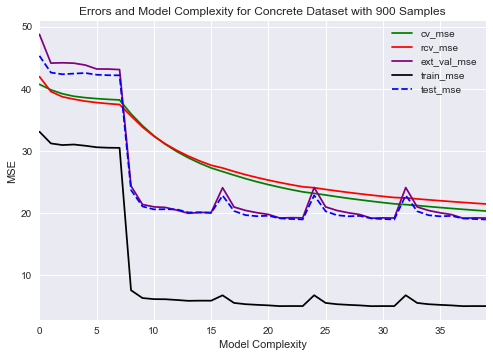

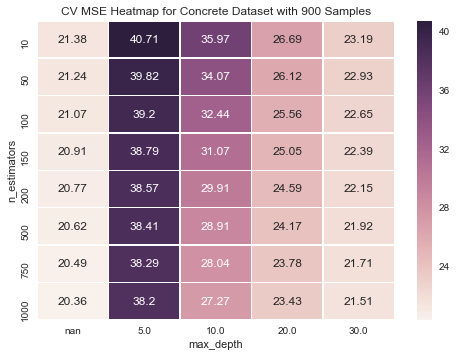

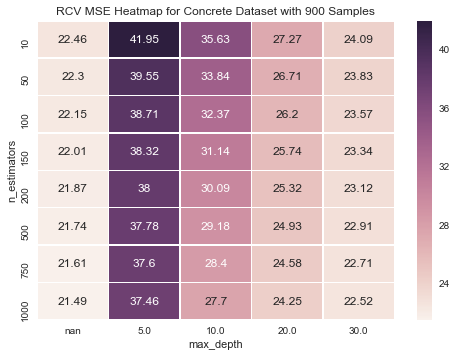

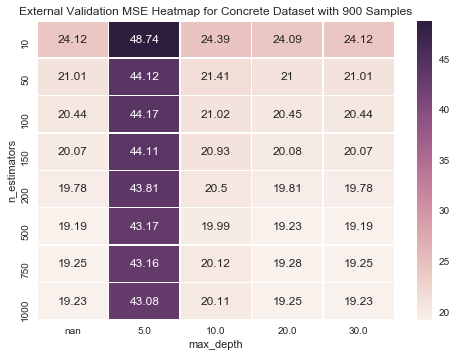

n_estimator: 500.0 max_depth: 30.0 MSE: 19.1906005298


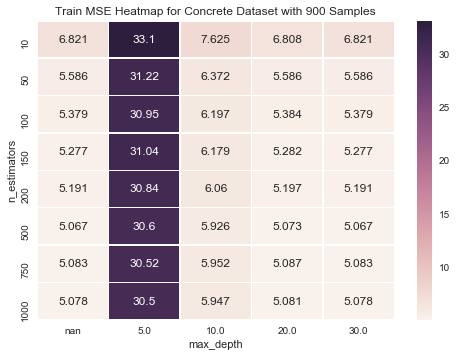

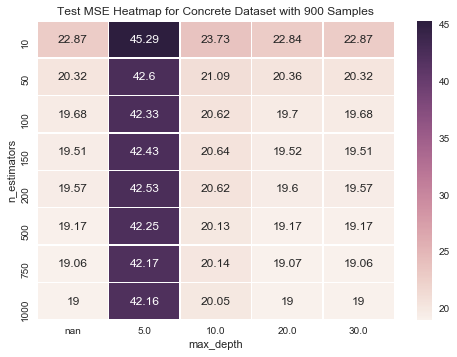

In [213]:
#store best parameters and score
best_score = outputs['ext_val_mse'].min()
best_score_rows = outputs.loc[(outputs['ext_val_mse'] == best_score)]
if len(best_score_rows.index) == 1:
    best_parameters = best_score_rows
elif len(best_score_rows.index) > 1:
    best_parameters = best_score_rows.loc[best_score_rows['n_estimators'] == best_score_rows['n_estimators'].min()] 

best_n_estimator = best_parameters.iloc[0]['n_estimators']
best_max_depth = best_parameters.iloc[0]['max_depth']
best_mse = best_parameters.iloc[0]['ext_val_mse']

#plot line graph
ax = plt.gca()
outputs2.plot(kind='line', y='cv_mse',ax=ax, color ='green')
outputs2.plot(kind='line', y='rcv_mse',ax=ax, color ='red')
outputs2.plot(kind='line', y='ext_val_mse',ax=ax, color = 'purple')
outputs2.plot(kind='line', y='train_mse',ax=ax, color ='black')
outputs2.plot(linestyle='dashed', y='test_mse', ax=ax, color ='blue')
plt.title("Errors and Model Complexity for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.xlabel('Model Complexity')
plt.ylabel('MSE')
plt.show()

#plot heatmap
outputs_cv_train = outputs.pivot('n_estimators', 'max_depth', 'cv_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("CV MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()

outputs_cv_train = outputs.pivot('n_estimators', 'max_depth', 'rcv_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("RCV MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()

outputs_ext_valid = outputs.pivot('n_estimators', 'max_depth', 'ext_val_mse')
sns.heatmap(outputs_ext_valid, annot=True, linewidths=.5, fmt='.4g')
plt.title("External Validation MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()

print('n_estimator:', best_n_estimator, 'max_depth:', best_max_depth, 'MSE:', best_mse)

outputs_train = outputs.pivot('n_estimators', 'max_depth', 'train_mse')
sns.heatmap(outputs_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("Train MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()

outputs_test = outputs.pivot('n_estimators', 'max_depth', 'test_mse')
sns.heatmap(outputs_test, annot=True, linewidths=.5, fmt='.4g')
plt.title("Test MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()


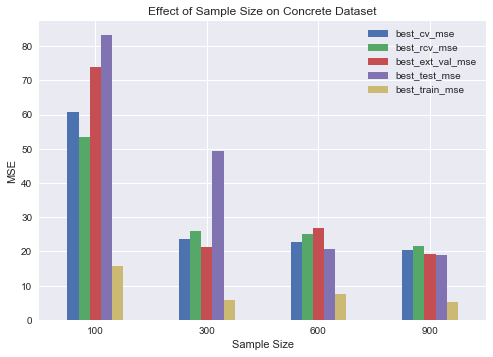

In [180]:

concrete_table = pd.read_csv("concrete_sampe_size.csv")
concrete_table = concrete_table.set_index('sample_size')
#concrete_table
#ax = plt.gca()
ax = concrete_table.plot.bar(rot=0)
#concrete_table.plot(kind='line', y='best_cv_mse', ax=ax)
#concrete_table.plot(kind='line', y='best_rcv_mse',ax=ax)
#concrete_table.plot(kind='line', y='best_ext_val_mse',ax=ax)
#concrete_table.plot(kind='line', y='best_train_mse',ax=ax)
#concrete_table.plot(linestyle='dashed', y='best_test_mse', ax=ax)
plt.title("Effect of Sample Size on Concrete Dataset")
plt.xlabel('Sample Size')
plt.ylabel('MSE')
plt.show()

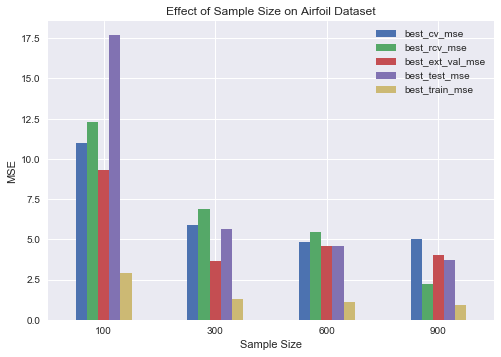

In [178]:
airfoil_table = pd.read_csv("airfoil_sampe.csv")
airfoil_table = airfoil_table.set_index('sample_size')
#concrete_table
#ax = plt.gca()
ax = airfoil_table.plot.bar(rot=0)
#airfoil_table.plot(kind='line', y='best_cv_mse', ax=ax)
#airfoil_table.plot(kind='line', y='best_rcv_mse',ax=ax)
#airfoil_table.plot(kind='line', y='best_ext_val_mse',ax=ax)
#airfoil_table.plot(kind='line', y='best_train_mse',ax=ax)
#airfoil_table.plot(linestyle='dashed', y='best_test_mse', ax=ax)
plt.title("Effect of Sample Size on Airfoil Dataset")
plt.xlabel('Sample Size')
plt.ylabel('MSE')
plt.show()

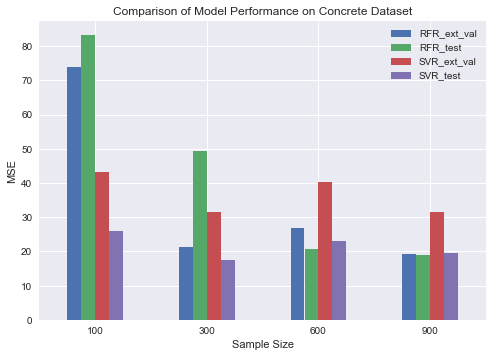

In [215]:
best_on_concrete = pd.read_csv("best_on_concrete.csv")
best_on_concrete = best_on_concrete.set_index('sample_size')
ax = best_on_concrete.plot.bar(rot=0)
plt.ylabel('MSE')
plt.xlabel('Sample Size')
plt.title('Comparison of Model Performance on Concrete Dataset')
plt.show()

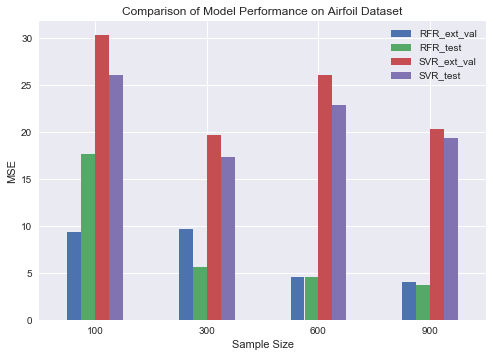

In [214]:
best_on_airfoil = pd.read_csv("best_on_airfoil.csv")
best_on_airfoil = best_on_airfoil.set_index('sample_size')
ax = best_on_airfoil.plot.bar(rot=0)
plt.ylabel('MSE')
plt.xlabel('Sample Size')
plt.title('Comparison of Model Performance on Airfoil Dataset')
plt.show()

# Tests

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#rf = RandomForestRegressor(random_state=42)
rf.fit(Xdata1, ydata1)
predictions = rf.predict(Xdata2)
mse = metrics.mean_squared_error(ydata2, predictions)
print('MSE:', mse)
plt.scatter(ydata2, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual values on training set')
plt.show()


In [87]:
print(rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


In [ ]:
compare = pd.DataFrame({'Actual': ydata2, 'Predicted': predictions})
compare.head()